In [8]:
%matplotlib inline

import os, sys
from functools import partial

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from ignite.engine import Events, create_supervised_trainer

# assumes the framework is found here, change as necessary
sys.path.append("..")

from monai import application, data, networks, utils
import monai.data.augments.augments as augments

application.config.print_config()

MONAI version: 0.0.1
Python version: 3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC 7.3.0]
Numpy version: 1.16.4
Pytorch version: 1.3.1
Ignite version: 0.2.1


Download the downsampled segmented images from the Sunnybrook Cardiac Dataset. This is a simple low-res dataset I put together for a workshop. The task is to segment the left ventricle in the image which shows up as an annulus. 

In [2]:
! [ ! -f scd_lvsegs.npz ] &&  wget -q https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs.npz

Create the reader to bring the images in, these are initially in uint16 format with no channels:

In [9]:
imSrc = data.readers.NPZReader("scd_lvsegs.npz", ["images", "segs"], orderType=data.streams.OrderType.CHOICE)

Define a stream to convert the image format, apply some basic augments using multiple threads, and buffer the stream behind a thread so that batching can be done in parallel with the training process.

(200, 1, 64, 64) float32 (200, 1, 64, 64) int32


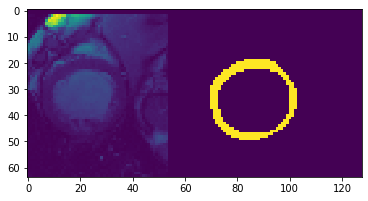

In [10]:
def normalizeImg(im, seg):
    im = utils.arrayutils.rescaleArray(im)
    im = im[None].astype(np.float32)
    seg = seg[None].astype(np.int32)
    return im, seg


augs = [
    normalizeImg,
    augments.rot90,
    augments.transpose,
    augments.flip,
    partial(augments.shift, dimFract=5, order=0, nonzeroIndex=1),
]

src = data.augments.augmentstream.ThreadAugmentStream(imSrc, 200, augments=augs)
src = data.streams.ThreadBufferStream(src)

im, seg = utils.mathutils.first(src)
print(im.shape, im.dtype, seg.shape, seg.dtype)
plt.imshow(np.hstack([im[0, 0], seg[0, 0]]))

Define the network, loss, and optimizer:

In [11]:
lr = 1e-3

net = networks.nets.UNet(
    dimensions=2,
    inChannels=1,
    numClasses=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    numResUnits=2,
)

loss = networks.losses.DiceLoss()
opt = torch.optim.Adam(net.parameters(), lr)

Train using an Ignite Engine:

In [13]:
trainSteps = 100
trainEpochs = 20
trainSubsteps = 1


def _prepare_batch(batch, device=None, non_blocking=False):
    x, y = batch
    return torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)


loss_fn = lambda i, j: loss(i[0], j)

trainer = create_supervised_trainer( net, opt, loss_fn, torch.device("cuda:0"), False, _prepare_batch)


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_loss(engine):
    print("Epoch", engine.state.epoch, "Loss:", engine.state.output)


fsrc = data.streams.FiniteStream(
    src, trainSteps
)  # finite stream to train only for as many steps as we specify
state = trainer.run(fsrc, trainEpochs)

Epoch 1 Loss: 0.8310171365737915
Epoch 2 Loss: 0.8060150742530823
Epoch 3 Loss: 0.7623872756958008
Epoch 4 Loss: 0.6729476451873779
Epoch 5 Loss: 0.6116510629653931
Epoch 6 Loss: 0.5286673903465271
Epoch 7 Loss: 0.4480087161064148
Epoch 8 Loss: 0.41203784942626953
Epoch 9 Loss: 0.3519987463951111
Epoch 10 Loss: 0.30135440826416016
Epoch 11 Loss: 0.274499773979187
Epoch 12 Loss: 0.2519426941871643
Epoch 13 Loss: 0.23030847311019897
Epoch 14 Loss: 0.22828155755996704
Epoch 15 Loss: 0.22576206922531128
Epoch 16 Loss: 0.23023653030395508
Epoch 17 Loss: 0.21913212537765503
Epoch 18 Loss: 0.22168612480163574
Epoch 19 Loss: 0.2222415804862976
Epoch 20 Loss: 0.20740610361099243


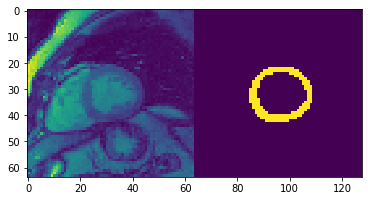

In [14]:
im, seg = utils.mathutils.first(imSrc)
testim = utils.arrayutils.rescaleArray(im[None, None])

pred = net.cpu()(torch.from_numpy(testim))

pseg = pred[1].data.numpy()

plt.imshow(np.hstack([testim[0, 0], pseg[0]]))